In [18]:
import os

# Third-party imports
import numpy as np
from jax import random as jr

# Foundational SSM imports
from omegaconf import OmegaConf

from foundational_ssm.utils.downstream_utils import get_rtt_datasets
from foundational_ssm.transform import smooth_spikes
from foundational_ssm.plotting import (
    aggregate_bin_label_results,
    plot_pred_vs_targets_by_angle_bin,
)
import joblib
import pandas as pd

%load_ext autoreload
%autoreload 2


def create_sliding_window_features(input_array, history_length=56):
    """
    Transform neural input data by applying a sliding window approach that concatenates
    historical timesteps for each output timestep.

    Parameters:
    -----------
    input_array : numpy.ndarray
        Input array of shape (batch_size, total_timesteps, features)
    history_length : int, optional
        Number of historical timesteps to include for each output, default is 56

    Returns:
    --------
    numpy.ndarray
        Transformed array with shape (batch_size, total_timesteps - history_length, features * history_length)
        where each timestep contains the flattened history window
    """
    batch_size, total_timesteps, features = input_array.shape
    output_timesteps = total_timesteps - history_length
    output_array = np.zeros((batch_size, output_timesteps, features * history_length))

    for t in range(output_timesteps):
        # Extract the history window for each timestep
        history_window = input_array[:, t : t + history_length, :]
        # Reshape to flatten the history dimension
        flattened_history = history_window.reshape(batch_size, -1)
        # Store the flattened history in the output array
        output_array[:, t, :] = flattened_history

    return output_array

In [3]:
cfg = OmegaConf.load("../configs/rtt.yaml")
train_data, val_data, data = get_rtt_datasets(cfg.dataset, jr.PRNGKey(0))

history_length = 56
train_inputs = smooth_spikes(train_data["neural_input"])
train_inputs = create_sliding_window_features(train_inputs, history_length)
train_targets = train_data["behavior_input"][
    :, history_length:, :
]  # Shape (378, 708, 1)
val_inputs = smooth_spikes(val_data["neural_input"])
val_inputs = create_sliding_window_features(val_inputs, history_length)
val_targets = val_data["behavior_input"][:, history_length:, :]  # Shape (378, 708, 1)

print("train_inputs shape:", train_inputs.shape)
print("train_targets shape:", train_targets.shape)
print("val_inputs shape:", val_inputs.shape)
print("val_targets shape:", val_targets.shape)

train_inputs shape: (378, 708, 7280)
train_targets shape: (378, 708, 2)
val_inputs shape: (163, 708, 7280)
val_targets shape: (163, 708, 2)


In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm

DO_CROSS_VALIDATION = False
RETRAIN_FINAL_MODEL = False

if DO_CROSS_VALIDATION:
    # CV Config
    alphas = [1e-5, 1e-4]
    n_epochs = 100
    batch_size = 64

    # Prepare data
    n_trials = train_inputs.shape[0]
    cv_folds = 3
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Init results
    alpha_scores = {alpha: [] for alpha in alphas}
    alpha_r2_scores = {alpha: [] for alpha in alphas}

    # Cross-validation loop
    for train_idx, val_idx in tqdm(kf.split(range(n_trials))):
        train_trials = train_idx
        val_trials = val_idx

        print(
            f"Cross-validation fold with {len(train_trials)} training trials and {len(val_trials)} validation trials"
        )

        # For each alpha value
        for alpha in alphas:
            print(f"Training model with alpha={alpha}")
            model = MultiOutputRegressor(
                SGDRegressor(
                    loss="squared_error",
                    alpha=alpha,
                    learning_rate="invscaling",
                    max_iter=1000,
                    tol=1e-3,
                )
            )

            best_train_mse = float("inf")
            epochs_no_improve = 0
            for epoch in range(n_epochs):
                np.random.shuffle(train_trials)

                for trial_batch_idx in range(0, len(train_trials), batch_size):
                    end_idx = min(trial_batch_idx + batch_size, len(train_trials))
                    current_trials = train_trials[trial_batch_idx:end_idx]

                    X_batch = np.vstack(
                        [
                            train_inputs[i].reshape(-1, train_inputs.shape[-1])
                            for i in current_trials
                        ]
                    )
                    y_batch = np.vstack(
                        [
                            train_targets[i].reshape(-1, train_targets.shape[-1])
                            for i in current_trials
                        ]
                    )
                    model.partial_fit(X_batch, y_batch)

                train_pred = model.predict(
                    train_inputs[train_trials].reshape(-1, train_inputs.shape[-1])
                )
                train_mse = mean_squared_error(
                    train_targets[train_trials].reshape(-1, train_targets.shape[-1]),
                    train_pred,
                )
                print(f"    Training MSE after epoch {epoch + 1}: {train_mse:.4f}")

                if best_train_mse > train_mse:
                    epochs_no_improve = 0
                    best_train_mse = train_mse
                else:
                    epochs_no_improve += 1

                if epochs_no_improve > 10:
                    print(f"    Training stopped early after {epoch + 1} epochs")
                    break

            # Evaluate on validation trials
            val_pred = model.predict(
                train_inputs[val_trials].reshape(-1, train_inputs.shape[-1])
            )
            val_mse = mean_squared_error(
                train_targets[val_trials].reshape(-1, train_targets.shape[-1]), val_pred
            )
            val_r2 = r2_score(
                val_pred, train_targets[val_trials].reshape(-1, train_targets.shape[-1])
            )
            print(
                f"alpha={alpha}| Validation MSE : {val_mse:.4f} | R2 Score: {val_r2:.4f}"
            )
            alpha_scores[alpha].append(val_mse)
            alpha_r2_scores[alpha].append(val_r2)

    # Calculate average score across folds for each alpha
    avg_scores = {alpha: np.mean(scores) for alpha, scores in alpha_scores.items()}
    best_alpha = min(avg_scores.items(), key=lambda x: x[1])[0]

    print("\nCross-validation results:")
    for alpha, score in sorted(avg_scores.items()):
        print(f"Alpha: {alpha}, Average MSE: {score:.4f}")
    print(f"\nBest alpha: {best_alpha}, MSE: {avg_scores[best_alpha]:.4f}")
else:
    best_alpha = 1e-5


if RETRAIN_FINAL_MODEL:
    print("\nTraining final model with best alpha...")
    final_model = MultiOutputRegressor(
        SGDRegressor(
            loss="squared_error",
            alpha=best_alpha,
            learning_rate="invscaling",
            max_iter=1000,
            tol=1e-3,
        )
    )

    # Train on all trials in batches
    for epoch in range(n_epochs):
        all_trials = np.random.permutation(n_trials)

        for trial_batch_idx in tqdm(range(0, n_trials, batch_size)):
            end_idx = min(trial_batch_idx + batch_size, n_trials)
            current_trials = all_trials[trial_batch_idx:end_idx]

            # Collect data from these trials
            X_batch = np.vstack(
                [
                    train_inputs[i].reshape(-1, train_inputs.shape[-1])
                    for i in current_trials
                ]
            )
            y_batch = np.vstack(
                [
                    train_targets[i].reshape(-1, train_targets.shape[-1])
                    for i in current_trials
                ]
            )
            final_model.partial_fit(
                X_batch,
                y_batch,
                classes=None,  # For regression
            )

    # Final evaluation on validation set
    y_pred = final_model.predict(val_inputs.reshape(-1, val_inputs.shape[-1]))

    final_val_mse = mean_squared_error(
        val_targets.reshape(-1, val_targets.shape[-1]), y_pred
    )
    final_val_r2 = r2_score(val_targets.reshape(-1, val_targets.shape[-1]), y_pred)
    print(
        f"\nFinal model validation MSE: {final_val_mse:.4f} | R2 Score: {final_val_r2:.4f}"
    )
else:
    final_model = joblib.load("linear_baseline.joblib")

In [5]:
dataset_dir = "../../data/foundational_ssm/processed/nlb"
trial_info = pd.read_csv(os.path.join(dataset_dir, "mc_rtt_trialized.csv"))
y_pred = final_model.predict(val_inputs.reshape(-1, val_inputs.shape[-1]))
final_val_mse = mean_squared_error(
    val_targets.reshape(-1, val_targets.shape[-1]), y_pred
)
final_val_r2 = r2_score(val_targets.reshape(-1, val_targets.shape[-1]), y_pred)
print(
    f"\nFinal model validation MSE: {final_val_mse:.4f} | R2 Score: {final_val_r2:.4f}"
)


Final model validation MSE: 740.4038 | R2 Score: 0.5513


In [19]:
target_vel = np.concatenate([train_targets, val_targets], axis=0)

pred_vel_train = final_model.predict(train_inputs.reshape(-1, train_inputs.shape[-1]))
pred_vel_val = final_model.predict(val_inputs.reshape(-1, val_inputs.shape[-1]))
pred_vel = np.concatenate([pred_vel_train, pred_vel_val], axis=0)

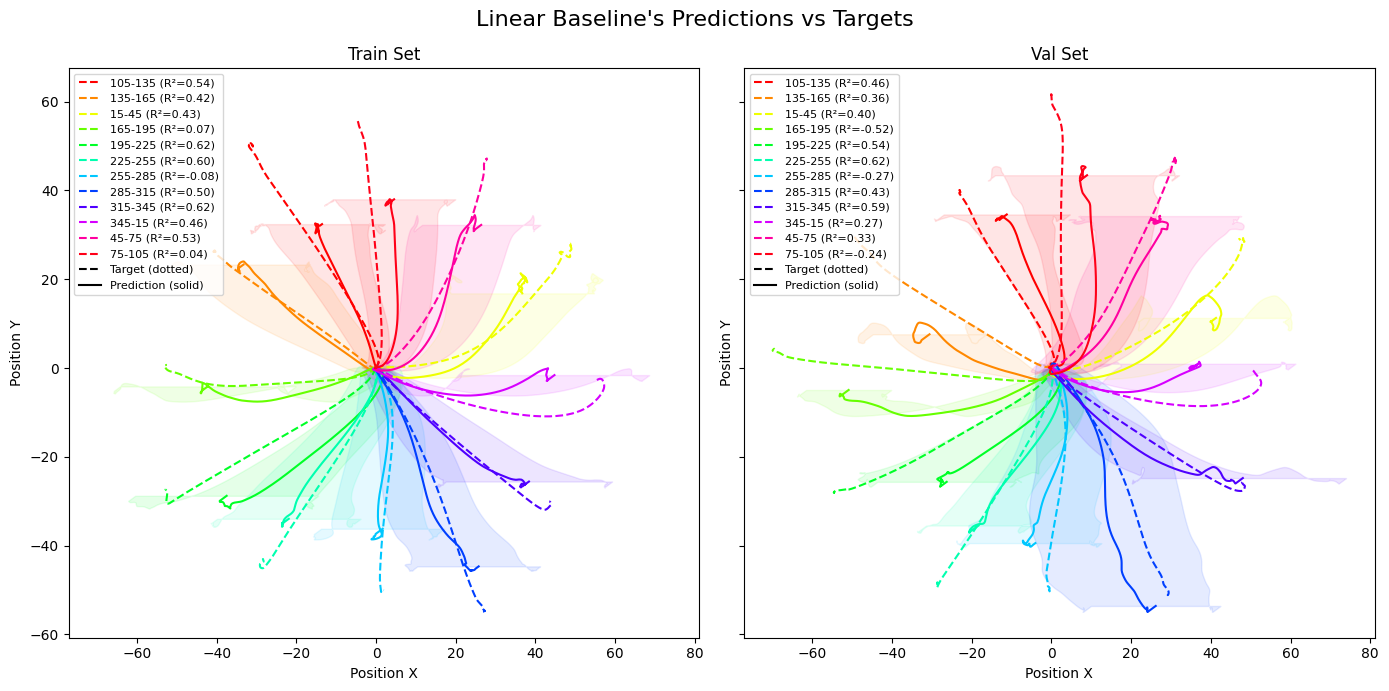

In [22]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_pred_vs_targets_by_angle_bin(results_df, suptitle=None, save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
    splits = ["train", "val"]
    colors = plt.cm.hsv(np.linspace(0, 1, len(results_df.angle_bin_label.unique())))

    for i, split in enumerate(splits):
        ax = axs[i]
        split_df = results_df[results_df["split"] == split]
        for j, row in split_df.reset_index().iterrows():
            label = row["angle_bin_label"]
            target_mean = row["target_pos_mean"]
            pred_mean = row["pred_pos_mean"]
            r2_val = row["r2"]
            error = row["error"]

            ax.plot(
                target_mean[:, 0],
                target_mean[:, 1],
                linestyle="--",
                color=colors[j],
                label=f"{label} (R²={r2_val:.2f})",
            )
            ax.plot(pred_mean[:, 0], pred_mean[:, 1], linestyle="-", color=colors[j])

            ax.fill_betweenx(
                pred_mean[:, 1],
                pred_mean[:, 0] - error[:, 0],
                pred_mean[:, 0] + error[:, 0],
                color=colors[j],
                alpha=0.1,
            )

        ax.set_title(f"{split.capitalize()} Set")
        ax.set_xlabel("Position X")
        ax.set_ylabel("Position Y")

        # Custom legend for line styles
        handles, labels_ = ax.get_legend_handles_labels()
        custom_lines = [
            Line2D([0], [0], color="black", linestyle="--", label="Target (dotted)"),
            Line2D([0], [0], color="black", linestyle="-", label="Prediction (solid)"),
        ]
        ax.legend(handles=handles + custom_lines, fontsize=8, loc="best")
    plt.suptitle(
        suptitle if suptitle else "Predicted vs Target Positions by Angle Bin",
        fontsize=16,
    )
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    return fig


results_df = aggregate_bin_label_results(
    trial_info,
    target_vel.reshape(541, -1, 2),
    pred_vel.reshape(541, -1, 2),
    skip_timesteps=0,
)
fig = plot_pred_vs_targets_by_angle_bin(
    results_df, suptitle="Linear Baseline's Predictions vs Targets"
)
fig.show()